In [1]:
import rlcard
from rlcard.envs.registration import register
from rlcard.utils import get_device, Logger, reorganize, plot_curve
from rlcard.agents import RandomAgent

from rlcard.agents import DQNAgent
from pseudo_optimal import PseudoOptimalAgent
import torch
import numpy as np
import argparse
import os
from copy import deepcopy



In [2]:

register(
    env_id='yaniv',
    entry_point='env:YanivEnv',
)
rlcard.make('yaniv', config={'game_num_players': 4})
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [3]:
baseline_env = rlcard.make('yaniv')
baseline_agents = [PseudoOptimalAgent(num_actions=baseline_env.num_actions)] + [RandomAgent(num_actions=baseline_env.num_actions) for _ in range(baseline_env.num_players - 1)]
baseline_env.set_agents(baseline_agents)

In [4]:
def tournament(env, num):
    payoffs = np.zeros(env.num_players)
    scores = np.zeros(env.num_players)
    calls = np.zeros(env.num_players)
    call_successes = np.zeros(env.num_players)
    hand_size = np.zeros(env.num_players)
    running_turns = 0
    counter = 0
    win_rates = np.zeros(env.num_players)
    
    while counter < num:
        _, _payoffs = env.run(is_training=False)
        game_scores = env.game.get_payoffs()
        scores += game_scores
        winner = np.argmin(game_scores)
        caller = env.game.round.caller_id
        calls[caller] += 1
        if winner == caller:
            call_successes[caller] += 1
        hand_size += [len(player.hand) for player in env.game.players]
        running_turns += len(env.action_recorder) / env.num_players
        payoffs += _payoffs
        win_rates[winner] += 1
        counter += 1

    call_success_rate = call_successes / calls
    payoffs /= counter
    win_rates /= counter
    scores /= counter
    hand_size /= counter
    calls /= counter
    
    return payoffs, win_rates, scores, hand_size, calls, call_success_rate, running_turns / counter

In [5]:

env = rlcard.make('yaniv')

eps_end = 0.3
lr = 0.000003
reward_tag = 'handsize'
layers = [64, 64, 64, 64]

agent = DQNAgent(
                replay_memory_size=100000,
                num_actions=env.num_actions,
                state_shape=env.state_shape[0],
                mlp_layers=layers,
                device=device, 
                discount_factor=0.99,
                batch_size=32,
                train_every=1, 
                update_target_estimator_every=10000,
                epsilon_decay_steps=14000000,
                epsilon_end=eps_end,
                learning_rate=lr)

env.set_agents([agent, agent, agent, agent])
RUN_ID = f'dqn_{agent.replay_memory_init_size}_{agent.batch_size}_{agent.train_every}_{agent.update_target_estimator_every}_{agent.epsilon_decay_steps}_{eps_end}_{lr}_{"-".join([str(s) for s in layers])}{reward_tag}'
from pathlib import Path
Path(f"./{RUN_ID}").mkdir(parents=True, exist_ok=True)

In [6]:
EPISODES_PER_PHASE = 100000
EVAL_EVERY = 10000
BASELINE_EVAL_GAMES = 1000


In [7]:
import pylab as pl
from IPython import display
import logging
import time
logging.basicConfig(filename='yaniv_training.log', level=logging.DEBUG)

In [8]:
eval_env = rlcard.make('yaniv')


optimal_win_rates = []
optimal_payoffs = []
optimal_scores = []
optimal_opp_scores = []
optimal_turns = []
optimal_hand_sizes = []
optimal_call_success_rate = []
optimal_calls = []
optimal_opp_calls = []

optimal_opp_hand_sizes = []
optimal_opp_call_success_rate = []

win_rate_fig = pl.figure()
payoff_fig = pl.figure()
score_fig = pl.figure()
turn_fig = pl.figure()
hand_size_fig = pl.figure()
call_success_fig = pl.figure()
call_fig = pl.figure()
time_start = time.time()


figs = [win_rate_fig, payoff_fig, score_fig, turn_fig, hand_size_fig, call_success_fig, call_fig]


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [9]:
from types import MethodType

def reward_hand_minimization(game):
    handsize_sum = sum([len(player.hand) for player in game.players])
    return [(handsize_sum-len(player.hand))/3 - len(player.hand) for player in game.players]

def reward_score_minimization_and_opp_score_maximization(game):
    payoffs = game.get_payoffs()
    payoff_sum = sum(payoffs)
    return [((payoff_sum - payoff)/(len(payoffs)-1)) - payoff for payoff in payoffs]


reward_phases = [
    (reward_hand_minimization, 200000)
]

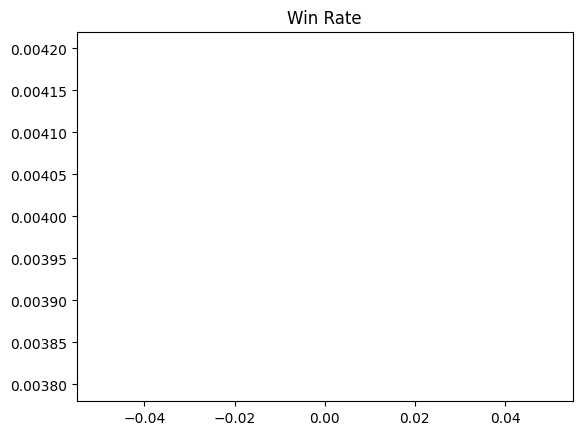

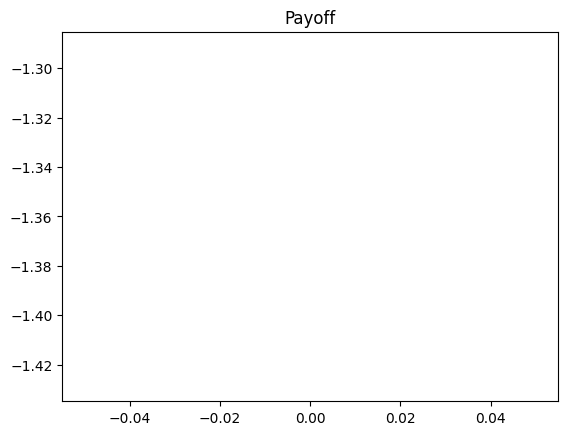

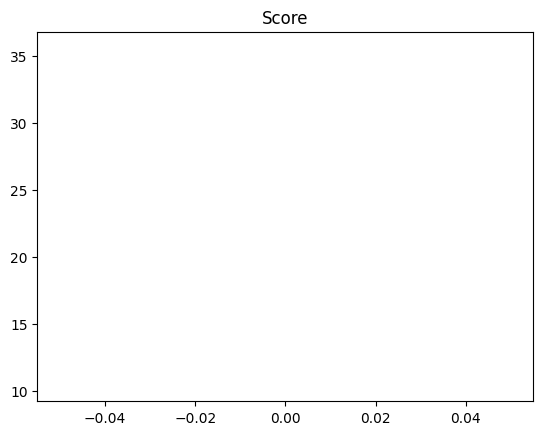

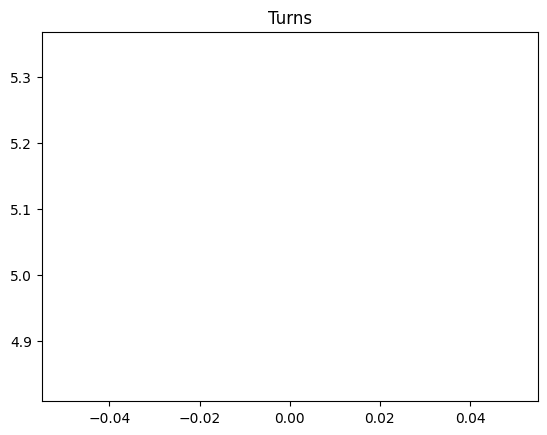

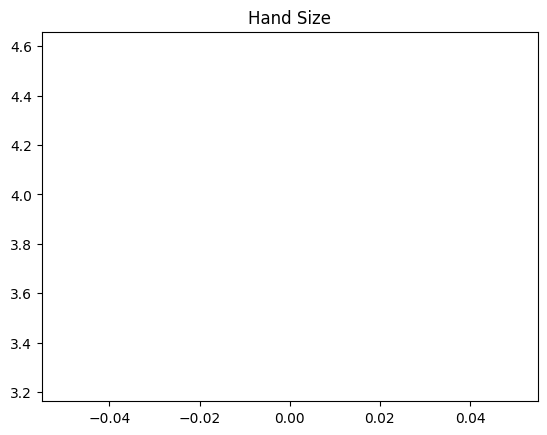

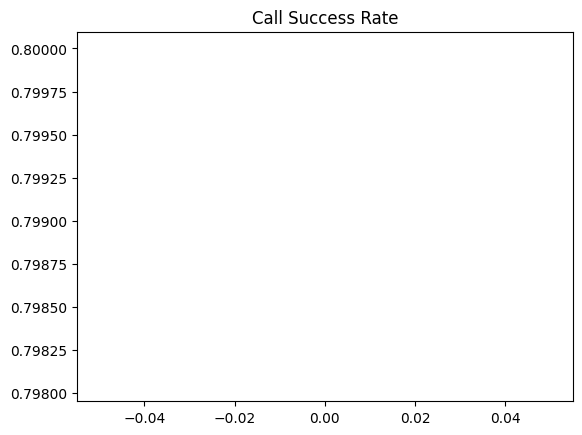

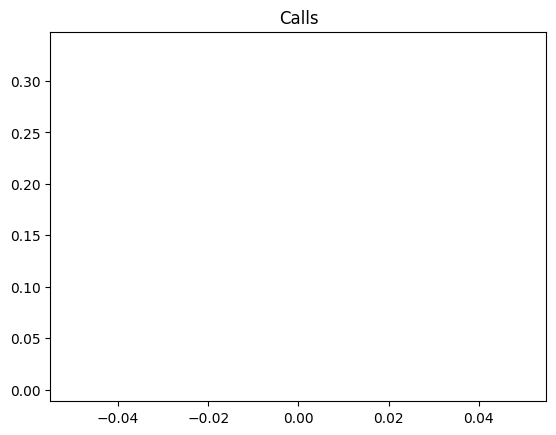

In [10]:
total_episodes = sum([episodes for _, episodes in reward_phases])
episode_num = 0
for phase_index, (phase, phase_episodes) in enumerate(reward_phases):
    env.set_payoff_fn(phase)
    eval_env.set_payoff_fn(phase)
    for _ in range(phase_episodes):
        
        trajectories, payoffs = env.run(is_training=True)
        
        trajectories = reorganize(trajectories, payoffs)
        for trajectory in trajectories:
            for ts in trajectory:
                env.agents[0].feed(ts)

        
        if episode_num % EVAL_EVERY == 0:
            cur_agent = env.agents[0]
            eval_env.set_agents([cur_agent] + [PseudoOptimalAgent(num_actions=eval_env.num_actions) for _ in range(eval_env.num_players - 1)])
            payoffs, win_rates, scores, hand_sizes, calls, call_success_rate, mean_turns = tournament(eval_env, BASELINE_EVAL_GAMES)
            optimal_payoffs.append(payoffs[0])
            optimal_scores.append(scores[0])
            optimal_opp_scores.append(np.mean(scores[1:]))
            optimal_turns.append(mean_turns)
            optimal_win_rates.append(win_rates[0])
            optimal_calls.append(calls[0])
            optimal_hand_sizes.append(hand_sizes[0])
            optimal_call_success_rate.append(call_success_rate[0] if calls[0] > 0 else (optimal_call_success_rate[-1] if len(optimal_call_success_rate) > 0 else 0))
            optimal_opp_call_success_rate.append(np.mean(call_success_rate[1:]))
            optimal_opp_calls.append(np.mean(calls[1:]))
            optimal_opp_hand_sizes.append(np.mean(hand_sizes[1:]))

            # update each figure with new data, and display
            for i, fig in enumerate(figs):
                fig.clf()
                ax = fig.add_subplot(111)
                if i == 0:
                    ax.plot(optimal_win_rates)
                    ax.set_title('Win Rate')
                elif i == 1:
                    ax.plot(optimal_payoffs)
                    ax.set_title('Payoff')
                elif i == 2:
                    ax.plot(optimal_scores)
                    ax.plot(optimal_opp_scores)
                    ax.set_title('Score')
                elif i == 3:
                    ax.plot(optimal_turns)
                    ax.set_title('Turns')
                elif i == 4:
                    ax.plot(optimal_hand_sizes)
                    ax.plot(optimal_opp_hand_sizes)
                    ax.set_title('Hand Size')
                elif i == 5:
                    ax.plot(optimal_call_success_rate)
                    ax.plot(optimal_opp_call_success_rate)
                    ax.set_title('Call Success Rate')
                elif i == 6:
                    ax.plot(optimal_calls)
                    ax.plot(optimal_opp_calls)
                    ax.set_title('Calls')
            display.clear_output(wait=True)
            for fig in figs:
                display.display(fig)


            with open(f'./{RUN_ID}/training_log.txt', 'a') as f:
                f.write(
                    '\n'.join([f'EPISODE: {episode_num}',
                        f'Training steps: {env.timestep}',
                        f'Mean Payoff: {optimal_payoffs[-1]:.03f}',
                        f'Mean Score: {optimal_scores[-1]:.03f}',
                        f'Mean Opponent Score: {optimal_opp_scores[-1]:.03f}',
                        f'Mean Turns: {optimal_turns[-1]:.03f}',
                        f'Win Rate: {optimal_win_rates[-1]:.03f}',
                        f'Call Rate: {optimal_calls[-1]:.03f}',
                        f'Call Success Rate: {optimal_call_success_rate[-1]:.03f}',
                        f'Opponent Call Success Rate: {np.mean(optimal_opp_call_success_rate[-1]):.03f}',
                        f'Mean EOG Opponent Hand Size: {np.mean(optimal_opp_hand_sizes[-1]):.03f}',
                        f'Mean EOG Hand Size: {optimal_hand_sizes[-1]:.03f}',
                        f'DQN Epsilon: {cur_agent.cur_epsilon:.03f}',
                        f'Reward Function {str(phase)}',
                        f'ETA: {((time.time() - time_start) / (episode_num + 1)) * (total_episodes - episode_num) / 60:.02f} minutes',
                        f'------------------------------------------------'
                    ]) + '\n'
                )
        episode_num += 1
            


In [ ]:
# save the model
save_path = os.path.join(f'./{RUN_ID}', f'model.pth')
torch.save(env.agents[0], save_path)
print('Model saved in', save_path)

Model saved in ./dqn_100_32_1_10000_5000000_0.25_0.0001_handsize/model.pth


In [ ]:

for fig in figs:
    fig.savefig(f'./{RUN_ID}/fig_{fig.axes[0].get_title()}.png')